In [311]:
# upload data
# libraries extraction
import glob 
import os 
import pandas as pd
import numpy as np 
from scipy.stats import ttest_ind 
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt 

In [312]:

df = pd.read_csv('C:/Users/Betty Reinhardova/Desktop/University/Thesis - Ms/data/data_thesis.csv')
df.head(3)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,...,revt,sale,seq,wcap,xrd,costat,mkvalt,gsector,sic,state
0,1004,31/05/2013,2012,INDL,C,D,STD,AIR,AAR CORP,USD,...,2167.1,2167.1,918.6,644.7,NaN,A,790.0029,20.0,5080,IL
1,1004,31/05/2014,2013,INDL,C,D,STD,AIR,AAR CORP,USD,...,2035.0,2035.0,999.5,714.8,NaN,A,961.3080,20.0,5080,IL
2,1004,31/05/2015,2014,INDL,C,D,STD,AIR,AAR CORP,USD,...,1594.3,1594.3,845.1,542.1,NaN,A,1046.3954,20.0,5080,IL


In [313]:
#creating unique ID
df['id'] = df.index + 1
df.head()
df['id'].count()

56013

In [314]:
#remove rows that do not have tic code
#filter out tic codes that are shorter than 4 or five letters = no special characters...
#remove sic in range of 4900-4999 (including)
#remove sic in range of 6000-6999 (including)
df['tic'] = df['tic'].astype("string")
df.dropna(subset=['tic'], inplace=True) 

df.dropna(subset=['sic'], inplace=True)
print(df['tic'].count())
print(df['tic'].str.len())

#FILTER TIC ONLY 4-5 LETTERS
#print(df.dtypes) 
#print(((df['tic'].str.len() ==5) | (df['tic'].str.len() ==4)).count())
#df.drop(df[(df['tic'].str.len() ==5) | (df['tic'].str.len() ==4)].index, inplace=True)

#print(df['tic'].str.match('[A-z]{4,5}'))

df[(df['tic'].str.match('[A-z]{4,5}'))]

df.drop(df[(df['sic'] >= 4900) & (df['sic'] <= 4999)].index, inplace=True)
df.drop(df[(df['sic'] >= 6000) & (df['sic'] <= 6999)].index, inplace=True)
df.drop(df[(df['fyear'] <=2012)].index, inplace=True)
#df['id'].count()
df.drop(df.columns[[3,4,5,6,10,32]], axis=1, inplace=True)

df.shape[0]

55998
0        3
1        3
2        3
3        3
4        3
        ..
56008    4
56009    4
56010    4
56011    5
56012    5
Name: tic, Length: 55998, dtype: Int64


27372

In [315]:
#df['xrd'].fillna(0,inplace=True)
#df['at'].fillna(0,inplace=True)
# df['wcap'].fillna(0,inplace=True)
# df['ebit'].fillna(0,inplace=True)
# df['re'].fillna(0,inplace=True)
# df['sale'].fillna(0,inplace=True)
# df['derac'].fillna(0,inplace=True)
# df['deralt'].fillna(0,inplace=True)
# df['derlc'].fillna(0,inplace=True)
# df['derllt'].fillna(0,inplace=True)
# df['cidergl'].fillna(0,inplace=True)
# df['lt'].fillna(0,inplace=True)
# df.head(30)

In [316]:
df.dropna(subset=['xrd','at', 'wcap','re','ebit','sale','ebitda','mkvalt','lt', 'fyear'], inplace=True)

In [317]:
df['rd intensity'] = df['xrd'] / df['at']
#create new variable - R&D intensity = R&D expenditure / TA
df['financial distress prob'] = (1.2 * df['wcap'] + 1.4 * df['re'] + 3.3 * df['ebit'] + 0.999 * df['sale'])/df['at']
#create new variable - Altman Z-score = (1.2 x WC + 1.4 x RE + 3.3 x EBIT + 0.999 x Sales)/TA -> score lower than 1.65 = risky business -> please check the range and go back to thesis page 26
df['hedging intensity'] = (df['derac'] + df['deralt'] + df['derlc']) + df['derllt'] / df['at']

df['Altman-z score NA'] = ((1.2 * df['wcap'] + 1.4 * df['re'] + 3.3 * df['ebit'] + 1 * df['sale'])/df['at']) + (0.6 * (df['mkvalt']/df['lt']))
#not adjusted Altman-z

#df['hedging intensity'].fillna(0,inplace=True)
#df['rd intensity'].fillna(0,inplace=True)
#df['financial distress prob'].fillna(0,inplace=True)
#df[['rd intensity', 'hedging intensity']].replace(np.nan, 0)


df.head(10)
#df.dtypes


,gvkey,datadate,fyear,tic,conm,curcd,at,cidergl,derac,deralt,...,xrd,mkvalt,gsector,sic,state,id,rd intensity,financial distress prob,hedging intensity,Altman-z score NA
49,1078,31/12/2013,2013,ABT,ABBOTT LABORATORIES,USD,42953.000,-53.0,84.0,87.0,...,1452.000,59338.5963,35.0,3845,IL,50,0.033804,1.636490,751.000000,3.650069
50,1078,31/12/2014,2014,ABT,ABBOTT LABORATORIES,USD,41275.000,94.0,257.0,101.0,...,1345.000,67891.7357,35.0,3845,IL,51,0.032586,1.466022,933.000000,3.541021
51,1078,31/12/2015,2015,ABT,ABBOTT LABORATORIES,USD,41247.000,-35.0,179.0,116.0,...,1405.000,66137.3852,35.0,3845,IL,52,0.034063,1.556806,836.000000,3.549291
52,1078,31/12/2016,2016,ABT,ABBOTT LABORATORIES,USD,52666.000,-15.0,276.0,8.0,...,1422.000,56572.8983,35.0,3845,IL,53,0.027000,1.567363,820.001405,2.630194
53,1078,31/12/2017,2017,ABT,ABBOTT LABORATORIES,USD,76250.000,-134.0,138.0,0.0,...,2235.000,99507.3661,35.0,3845,IL,54,0.029311,1.037558,343.001220,2.360216
54,1078,31/12/2018,2018,ABT,ABBOTT LABORATORIES,USD,67173.000,136.0,114.0,0.0,...,2300.000,126983.9223,35.0,3845,IL,55,0.034240,1.119382,209.001489,3.210050
55,1078,31/12/2019,2019,ABT,ABBOTT LABORATORIES,USD,67887.000,-53.0,148.0,48.0,...,2440.000,153091.0106,35.0,3845,IL,56,0.035942,1.157909,285.000000,3.669028
70,1104,31/12/2013,2013,ACU,ACME UNITED CORP,USD,68.079,0.0,NaN,NaN,...,0.603,47.6949,20.0,3420,CT,71,0.008857,3.034706,NaN,3.901261
71,1104,31/12/2014,2014,ACU,ACME UNITED CORP,USD,79.308,0.0,NaN,NaN,...,0.665,65.7871,20.0,3420,CT,72,0.008385,2.875805,NaN,3.866933
72,1104,31/12/2015,2015,ACU,ACME UNITED CORP,USD,81.421,0.0,NaN,NaN,...,0.690,58.2552,20.0,3420,CT,73,0.008474,2.962858,NaN,3.878325


In [318]:
#df['dummy hedge'] = pd.get_dummies(df['hedging intensity'])
dummy_hedge = df['hedge group'] = (df['hedging intensity'] > 0).astype(int)
#hedger = dummy_hedge==1
#nonhedger = dummy_hedge==0
#hedger = [df['hedge group'] == 1]
#nonhedger = [df['hedge group] == 0]
df.head(10)



,gvkey,datadate,fyear,tic,conm,curcd,at,cidergl,derac,deralt,...,mkvalt,gsector,sic,state,id,rd intensity,financial distress prob,hedging intensity,Altman-z score NA,hedge group
49,1078,31/12/2013,2013,ABT,ABBOTT LABORATORIES,USD,42953.000,-53.0,84.0,87.0,...,59338.5963,35.0,3845,IL,50,0.033804,1.636490,751.000000,3.650069,1
50,1078,31/12/2014,2014,ABT,ABBOTT LABORATORIES,USD,41275.000,94.0,257.0,101.0,...,67891.7357,35.0,3845,IL,51,0.032586,1.466022,933.000000,3.541021,1
51,1078,31/12/2015,2015,ABT,ABBOTT LABORATORIES,USD,41247.000,-35.0,179.0,116.0,...,66137.3852,35.0,3845,IL,52,0.034063,1.556806,836.000000,3.549291,1
52,1078,31/12/2016,2016,ABT,ABBOTT LABORATORIES,USD,52666.000,-15.0,276.0,8.0,...,56572.8983,35.0,3845,IL,53,0.027000,1.567363,820.001405,2.630194,1
53,1078,31/12/2017,2017,ABT,ABBOTT LABORATORIES,USD,76250.000,-134.0,138.0,0.0,...,99507.3661,35.0,3845,IL,54,0.029311,1.037558,343.001220,2.360216,1
54,1078,31/12/2018,2018,ABT,ABBOTT LABORATORIES,USD,67173.000,136.0,114.0,0.0,...,126983.9223,35.0,3845,IL,55,0.034240,1.119382,209.001489,3.210050,1
55,1078,31/12/2019,2019,ABT,ABBOTT LABORATORIES,USD,67887.000,-53.0,148.0,48.0,...,153091.0106,35.0,3845,IL,56,0.035942,1.157909,285.000000,3.669028,1
70,1104,31/12/2013,2013,ACU,ACME UNITED CORP,USD,68.079,0.0,NaN,NaN,...,47.6949,20.0,3420,CT,71,0.008857,3.034706,NaN,3.901261,0
71,1104,31/12/2014,2014,ACU,ACME UNITED CORP,USD,79.308,0.0,NaN,NaN,...,65.7871,20.0,3420,CT,72,0.008385,2.875805,NaN,3.866933,0
72,1104,31/12/2015,2015,ACU,ACME UNITED CORP,USD,81.421,0.0,NaN,NaN,...,58.2552,20.0,3420,CT,73,0.008474,2.962858,NaN,3.878325,0


In [319]:
# CONTROL VARIABLES
df['size'] = np.log(df['at'])
# SIZE = natural log of bv assets
df['fp'] = df['ebitda'] / df['at'] 
# FP = EBITDA / TA
df['ast'] = df['ppent'] / df['at']
#AST = PP&E / TA 
df['mb'] = df['mkvalt']/ (df['at'] - df['lt']) 
# M/B = market value of equity+ book value of debt / TA   CHECK
df['leve'] = df['lt']
# Leve
df['sector'] = df['sic']
# SECTOR = fixed effect
df['time'] = df['fyear']
# TIME
df['defr'] = df['financial distress prob']
# Def R = altman zcosre
# df['size'].fillna(0,inplace=True)
# df['fp'].fillna(0,inplace=True)
# df['ast'].fillna(0,inplace=True)
# df['mb'].fillna(0,inplace=True)
# df['leve'].fillna(0,inplace=True)
# df['defr'].fillna(0,inplace=True)
df.head(10), df.shape

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(    gvkey    datadate  fyear  tic                 conm curcd         at  \
 49   1078  31/12/2013   2013  ABT  ABBOTT LABORATORIES   USD  42953.000   
 50   1078  31/12/2014   2014  ABT  ABBOTT LABORATORIES   USD  41275.000   
 51   1078  31/12/2015   2015  ABT  ABBOTT LABORATORIES   USD  41247.000   
 52   1078  31/12/2016   2016  ABT  ABBOTT LABORATORIES   USD  52666.000   
 53   1078  31/12/2017   2017  ABT  ABBOTT LABORATORIES   USD  76250.000   
 54   1078  31/12/2018   2018  ABT  ABBOTT LABORATORIES   USD  67173.000   
 55   1078  31/12/2019   2019  ABT  ABBOTT LABORATORIES   USD  67887.000   
 70   1104  31/12/2013   2013  ACU     ACME UNITED CORP   USD     68.079   
 71   1104  31/12/2014   2014  ACU     ACME UNITED CORP   USD     79.308   
 72   1104  31/12/2015   2015  ACU     ACME UNITED CORP   USD     81.421   
 
     cidergl  derac  deralt  ...  Altman-z score NA  hedge group       size  \
 49    -53.0   84.0    87.0  ...           3.650069            1  10.667862   
 50 

In [320]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['xrd','at', 'wcap','re','ebit','sale','ebitda','mkvalt','lt'], inplace=True)

In [321]:
# descriptive statistics -> ask if to get rid of outliers? bedause they are affecting means
from IPython.display import Image
descriptives_stat = np.round(df.describe(include='number'),2).transpose()[['count','mean','std','min','max']]
descriptives_stat.to_csv('descriptives_statistics.csv')
descriptives_stat.to_latex('summary stats.tex')
#Image(width=600, filename='Descriptives Statistics Table (LaTex).png')
descriptives_stat 

,count,mean,std,min,max
gvkey,12704.0,71627.27,71290.42,1078.00,332115.00
fyear,12704.0,2016.15,1.98,2013.00,2019.00
at,12704.0,5346.46,23731.86,0.00,551669.00
cidergl,12626.0,-0.24,49.41,-2282.25,1539.00
derac,3241.0,30.61,150.20,-29.58,4501.00
deralt,2652.0,22.12,95.50,-22.21,1396.10
derhedgl,4228.0,-0.75,62.93,-784.00,1411.00
derlc,4176.0,23.14,132.10,0.00,4427.00
derllt,3333.0,30.87,225.35,-8.66,7967.00
dlc,12704.0,218.48,1692.28,0.00,54313.00


In [322]:
# df['rd intensity'].isnull().sum()
# df['mb'].isnull().sum()
# df['fp'].isnull().sum()
# df['financial distress prob'].isnull().sum()
# df['financial distress prob'].dtypes

In [323]:
sic_codes = df.groupby(['sic']).sum()
sic_codes.index
sic_codes['rd intensity']

sic
100     2.582666
200     0.004447
1000    0.160161
1040    0.003703
1090    0.073744
          ...   
8734    0.120896
8741    0.250363
8742    0.285106
9995    2.596135
9997    0.247274
Name: rd intensity, Length: 289, dtype: float64

C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_13012\993444299.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sic_codes.index, rotation=0)


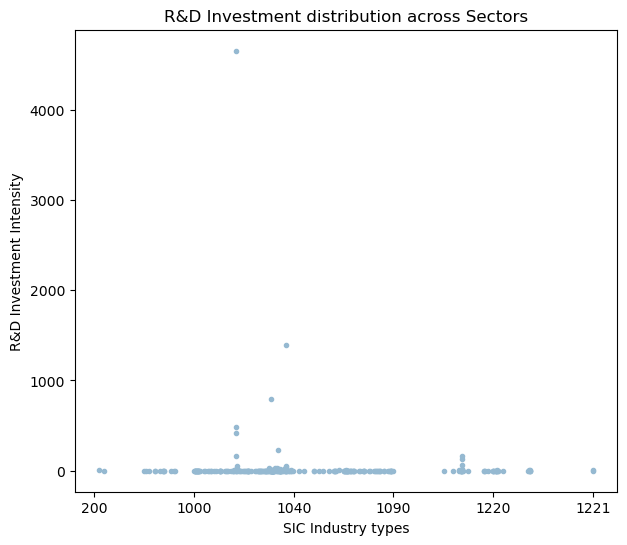

In [324]:
rd_investment = df['rd intensity']

# Create a bar chart
fig, ax = plt.subplots(figsize=(7,6))
# bar_chart = ax.bar(sic_codes.index, sic_codes['rd intensity'], color='#95b9d1')
bar_chart = ax.plot(sic_codes['rd intensity'], color='#95b9d1', marker='.',linestyle='none')

# Set chart title, labels, and rotation
ax.set_title('R&D Investment distribution across Sectors')
ax.set_ylabel('R&D Investment Intensity')
ax.set_xlabel('SIC Industry types')
ax.set_xticklabels(sic_codes.index, rotation=0)

# Display the chart
plt.show()
#ADJUST THE X AXIS

In [325]:
sorted_sic_codes = sic_codes.sort_values('rd intensity', ascending=False)
top_5_sic_codes = sorted_sic_codes['rd intensity'].head(5)
print(top_5_sic_codes)
#LOOKING AT THE TOP 5 SIC CODES WITH MOST R&D  

sic
2836    4653.523871
3845    1394.167500
3533     797.389769
2844     489.973185
2834     423.107818
Name: rd intensity, dtype: float64


In [326]:
median_rd_intensity = sic_codes['rd intensity'].median()
print(median_rd_intensity)
#we want to look if there are differences acorss above indistries in median or below median industries 

0.23521352328301726


C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_13012\1765673284.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['id'], rotation=0)


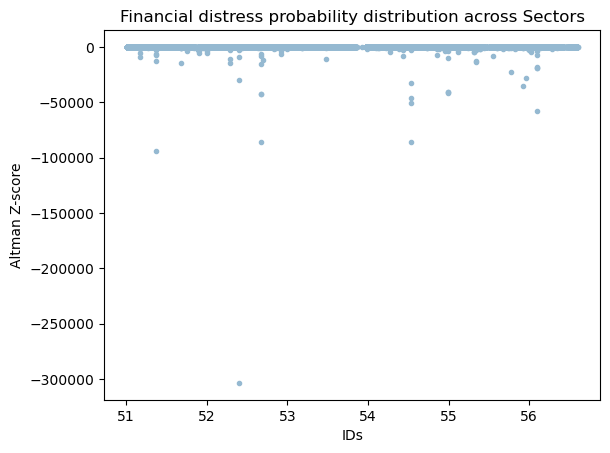

In [327]:
probability_fin_distress = df['financial distress prob']

# Create a bar chart
fig, ax = plt.subplots()
bar_chart = ax.scatter(df['id'], df['financial distress prob'], color='#95b9d1', marker='.')

# Set chart title, labels, and rotation
ax.set_title('Financial distress probability distribution across Sectors')
ax.set_ylabel('Altman Z-score')
ax.set_xlabel('IDs')
ax.set_xticklabels(df['id'], rotation=0)

# Display the chart
plt.show()

In [328]:
#CO S TIM??? SUMA NEFUNGUJE A NEUKAZUJE MI TO
# crate two lines of how much do they have across time? 
#hedgers vs non hedgers and altman zscore



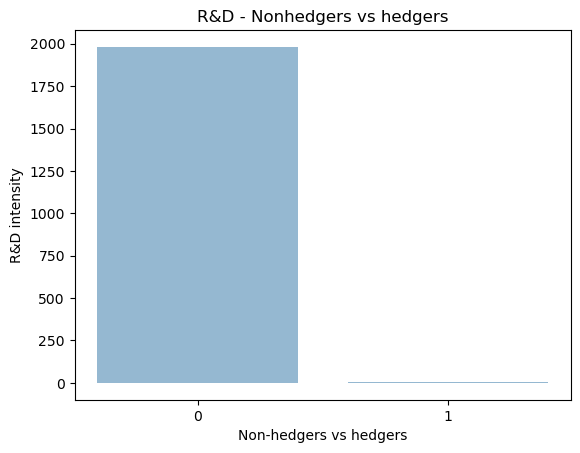

In [329]:
# Create a bar chart
fig, ax = plt.subplots()
bar_chart_hedgers_RD = ax.bar(df['hedge group'], rd_investment, color='#95b8d1')
#ZKUS TO ZNORMALIZOVAT MEZI 0-1

# Set chart title, labels, and rotation
ax.set_title('R&D - Nonhedgers vs hedgers')
ax.set_ylabel('R&D intensity')
ax.set_xlabel('Non-hedgers vs hedgers')
plt.xticks([0,1])

plt.show()

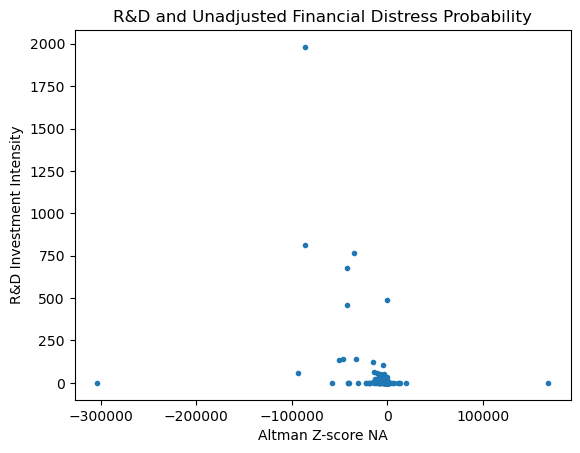

In [349]:
plt.scatter(df['Altman-z score NA'], df['rd intensity'], marker='.')
plt.title('R&D and Unadjusted Financial Distress Probability')
plt.xlabel('Altman Z-score NA')
plt.ylabel('R&D Investment Intensity')
plt.show()
#jestli jde udelat posunout osu -> zacinat v nule a jit i na minusi
#also there must be postiive values too? is it possible to get 0 in the middle and see the movement more closely? 

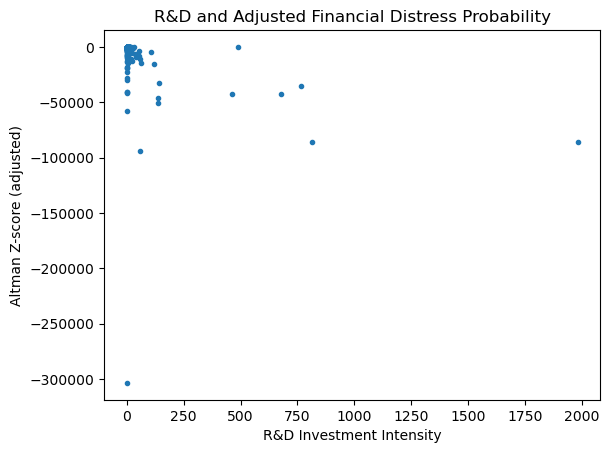

In [348]:
plt.scatter(df['rd intensity'], df['financial distress prob'], marker='.')
plt.title('R&D and Adjusted Financial Distress Probability')
plt.xlabel('R&D Investment Intensity')
plt.ylabel('Altman Z-score (adjusted)')
plt.show()
#jestli jde udel

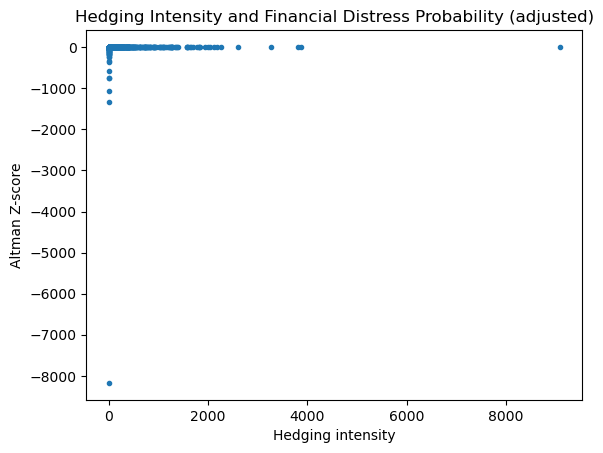

In [354]:
hedging_intensity = df['hedging intensity']
plt.scatter(df['hedging intensity'],df['financial distress prob'],marker='.')
plt.title('Hedging Intensity and Financial Distress Probability (adjusted)')
plt.xlabel('Hedging intensity')
plt.ylabel('Altman Z-score')
plt.show()

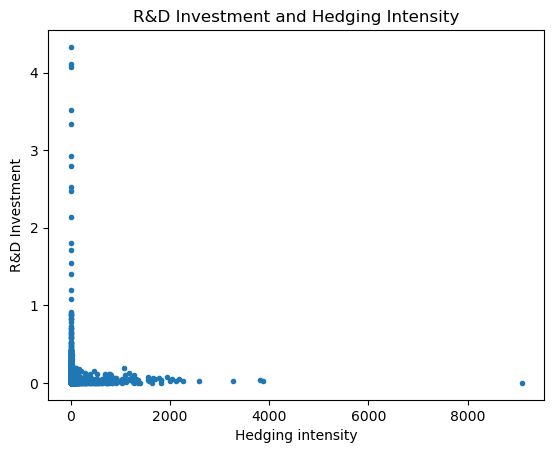

In [358]:
plt.scatter(df['hedging intensity'],df['rd intensity'],marker='.')
plt.title('R&D Investment and Hedging Intensity')
plt.xlabel('Hedging intensity')
plt.ylabel('R&D Investment')
plt.show()

In [359]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import statsmodels as stm 
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
import seaborn as sns
import scipy.stats as stats

In [364]:
#SUMMARY STATISTICS 1

# I need to lag all controls one year back because of the decision 
#df.groupby('hedge group')['financial distress prob'].describe(),2
statistics = df.groupby('hedge group')['financial distress prob'].describe().round(2)
transposed_statistics = statistics.T
transposed_statistics.to_csv('statistics.csv')

In [335]:
#INDEPENDENT T-TEST 1 LOOKING FOR STATISTICAL SIGNIFICANCE
group_1 = df[df['hedge group']==1]
group_2 = df[df['hedge group']==0]
group_2.dropna(subset=['financial distress prob'], inplace=True)
ttest_ind(group_1['financial distress prob'], group_2['financial distress prob'], nan_policy= 'raise')

#PROC TAM JE NAN V GROUP2 ??????
#ttest1_paired = ttest_rel(hedger['financial distress prob'],nonhedger['financial distress prob'])

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Ttest_indResult(statistic=1.6312748173205531, pvalue=0.10285719442622383)

In [366]:
group_2.dropna(subset=['Altman-z score NA'], inplace=True)
ttest_ind(group_1['Altman-z score NA'], group_2['Altman-z score NA'], nan_policy= 'raise')

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Ttest_indResult(statistic=1.185503381066639, pvalue=0.23584071199468595)

In [336]:
#SUMMARY STATISTICS 2
df.groupby('hedge group')['rd intensity'].describe(),2


(               count      mean        std       min       25%       50%  \
 hedge group                                                               
 0            11052.0  0.822862  23.671255 -0.506024  0.009459  0.062879   
 1             1622.0  0.041702   0.131056  0.000000  0.006042  0.018497   
 
                   75%          max  
 hedge group                         
 0            0.212501  1981.500000  
 1            0.046105     3.331081  ,
 2)

In [337]:
#INDEPENDENT T-TEST 2 
ttest_ind(group_1['rd intensity'], group_2['rd intensity'])

Ttest_indResult(statistic=-1.3290112733923027, pvalue=0.18386817873262604)

In [338]:
#HAUSMAN TEST
from linearmodels.iv import IV2SLS
from linearmodels.panel import compare
from linearmodels import PanelOLS 

random_effect_model_1 = PanelOLS.from_formula('financial distress prob ~ hedging intensity', df)
random_effect_model_1_results = random_effect_model_1.fit()

fixed_effect_model_1 = PanelOLS.from_formula('financial distress prob ~ hedging intensity + sic', df)
fixed_effect_model_1_results = fixed_effect_model_1.fit()

hausman_test_1 = compare({'Random Effects': random_effect_model_1_results, 'Fixed Effects': fixed_effect_model_1_results})
print(hausman_test_1)


FormulaSyntaxError: Missing operator between `financial` and `distress`.

0 + ⧛[1;31mfinancial distress[0m⧚ prob

In [ ]:
random_effect_model_2 = PanelOLS.from_formula('rd intensity ~ financial distress prob', df)
random_effect_model_2_results = random_effect_model_2.fit()

fixed_effect_model_2 = PanelOLS.from_formula('rd intensity ~ financial distress prob + sic', df)
fixed_effect_model_2_results = fixed_effect_model_2.fit()

hausman_test_2 = compare({'Random Effects': random_effect_model_2_results, 'Fixed Effects': fixed_effect_model_2_results})
print(hausman_test_2)

In [ ]:
random_effect_model_3 = PanelOLS.from_formula('rd intensity ~ hedging intensity', df)
random_effect_model_3_results = random_effect_model_3.fit()

fixed_effect_model_3 = PanelOLS.from_formula('rd intensity ~ hedging intensity + sic', df)
fixed_effect_model_3_results = fixed_effect_model_3.fit()

hausman_test_3 = compare({'Random Effects': random_effect_model_3_results, 'Fixed Effects': fixed_effect_model_3_results})
print(hausman_test_3)

In [ ]:
#IF HAUSMAN IS STATISTICALLY SIGNIFICANT P > 0.05 SUGGESTS THAT THERE IS A SIGNIFICANT
#DIFFERENCE BETWEEEN THE RANDOM EFFECTS AND FIXED EFFECTS MODELS =REJECT H0
#THAT THE RANDOME EFFECTS MODEL IS CONSISTENT AND EFFICIENT = CHOOSE FIXED EFFECTS MODEL 
#BECAUSE IT ACCOUNTS FOR UNOBSERVED VARIABLES 
#IF P < 0.05 = THERE IS NO SIGNIFICANT DIFFERENCE BETWEEN RANDOME AND FIXED MODELS 
#CHOOSE RANDOM EFFECTS MODEL 
#Random effects model is more appropriate if you assume that the unobserved 
#heterogeneity is not correlated with the independent variables, while fixed 
#effects model is more appropriate if you want to control for individual-specific
# effects

In [ ]:
#OLS = pooled 1
sns.scatterplot(x=df['hedging intensity'], y=df['financial distress prob'], hue=df['sic'])
plt.show()
#not workign cause of string -> is it becasue I do have Nan values? 

x_var_ols1 =
y_var_ols2 =
pooled_ols_1 = sm.OLS(endog=y_var_ols2,exog=x_var_ols1)
pooled_ols_1_results = pooled_ols_1.fit()
print(pooled_ols_1_results.summary()) 

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 825.202x583.564 with 1 Axes>

In [ ]:
#OLS = pooled 2 

In [ ]:
#Robustness test 